In [1]:
import sys
from pathlib import Path
import importlib.util
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi

# notebooks/.. = project_root
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


package_dir = project_root / "scdb_code_map"
init_file = package_dir / "__init__.py"
init_file.touch(exist_ok=True)  # creates empty __init__.py if missing


spec = importlib.util.find_spec("scdb_code_map")
if spec is None:
    raise ImportError(f"Cannot find 'scdb_code_map' in {project_root}")


from scdb_code_map import ISSUE_AREA_MAP, CASE_DISPOSITION_MAP, DECISION_DIRECTION_MAP, PETITIONER_MAP, DECISION_TYPE_MAP

In [2]:
conn = sqlite3.connect("../data/legal_sc.db")
c_citations = pd.read_sql("SELECT * FROM c_citations", conn)
conn.close()
print(c_citations.columns.tolist())

['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision', 'decisionType', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'term', 'naturalCourt', 'chief', 'docket', 'caseName', 'dateArgument', 'dateRearg', 'petitioner', 'petitionerState', 'respondent', 'respondentState', 'jurisdiction', 'adminAction', 'adminActionState', 'threeJudgeFdc', 'caseOrigin', 'caseOriginState', 'caseSource', 'caseSourceState', 'lcDisagreement', 'certReason', 'lcDisposition', 'lcDispositionDirection', 'declarationUncon', 'caseDisposition', 'caseDispositionUnusual', 'partyWinning', 'precedentAlteration', 'voteUnclear', 'issue', 'issueArea', 'decisionDirection', 'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2', 'lawType', 'lawSupp', 'lawMinor', 'majOpinWriter', 'majOpinAssigner', 'splitVote', 'majVotes', 'minVotes']


In [3]:
# Reversal Rate is the percentage of cases the supreme court reverse or vacate the lower court’s decision instead of affirming it
# the column I want to use is caseDisposition

# map caseDisposition code to English
c_citations["caseDispositionText"] = c_citations["caseDisposition"].map(CASE_DISPOSITION_MAP).fillna("Unknown")

print(f"Total Case Number is: {len(c_citations)}")
disposition_count = c_citations["caseDispositionText"].value_counts().sort_index()
print(disposition_count)

# Convert the Series to a DataFrame for export
disposition_count_df = disposition_count.to_frame()

# Change the name of the index (caseDispositionText is too long)
disposition_count_df.index.name = 'disposition'

dfi.export(
    disposition_count_df, 
    '../results/tbl_disposition_count.jpg', 
    table_conversion='matplotlib'
)

# Interpretation
# Only 50 out of over 9000 cases got affirmed decision
# consistent with the idea that the Court takes cases to reverse or change them, thus the high reversal rate

Total Case Number is: 9341
caseDispositionText
Affirmed (includes modified)                               2763
Affirmed and reversed (or vacated) in part                   76
Affirmed and reversed (or vacated) in part and remanded     170
Certification to or from a lower court                       13
No disposition                                                1
Petition denied or appeal dismissed                         364
Reversed                                                   2016
Reversed and remanded                                      2546
Stay, petition, or motion granted                            50
Unknown                                                     135
Vacated                                                      34
Vacated and remanded                                       1173
Name: count, dtype: int64


In [4]:
# Calculate Reversal Rate by Area

# map issue code to English, we already mapped disposition code to English earlier
c_citations["issueAreaText"] = c_citations["issueArea"].map(ISSUE_AREA_MAP).fillna("Unknown")

# Create a pivot table: counts of dispositions by issue area
disposition_by_area = (
    c_citations
    .pivot_table(
        index="issueAreaText",
        columns="caseDispositionText",
        aggfunc="size",
        fill_value=0
    )
    .sort_index()
)

print(disposition_by_area)

# observation
# In the entire dataase of over 9K cases, only 50 are affirmed, but 20 is in the area of Judicial Power

caseDispositionText   Affirmed (includes modified)  \
issueAreaText                                        
Attorneys                                       31   
Civil Rights                                   442   
Criminal Procedure                             601   
Due Process                                    109   
Economic Activity                              619   
Federal Taxation                               135   
Federalism                                     125   
First Amendment                                209   
Interstate Relations                             7   
Judicial Power                                 238   
Miscellaneous                                   15   
Privacy                                         33   
Private Law                                      2   
Unions                                         141   
Unknown                                         56   

caseDispositionText   Affirmed and reversed (or vacated) in part  \
issueAreaText

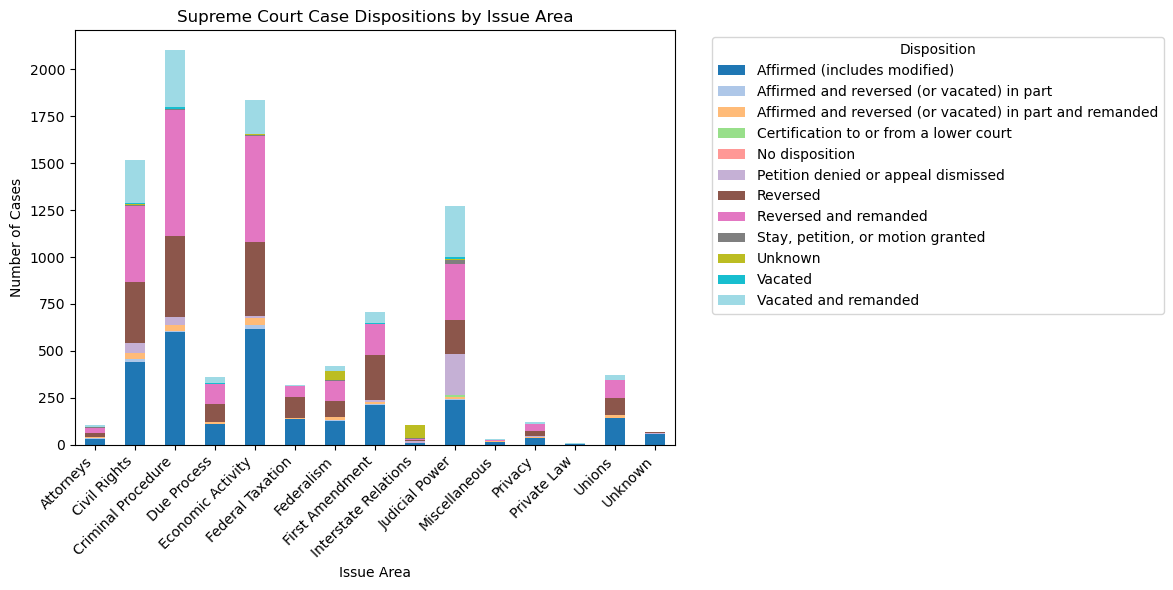

In [5]:
# plot disposition by issue area
disposition_by_area.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6),
    colormap='tab20'  # nice colors
)

plt.title("Supreme Court Case Dispositions by Issue Area")
plt.ylabel("Number of Cases")
plt.xlabel("Issue Area")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Disposition", bbox_to_anchor=(1.05, 1))
plt.tight_layout()

plt.savefig('../results/case_disposition_by_area.jpg', format='jpg', dpi=300)
plt.show()

In [6]:
# check the Supreme Court’s decision moves in a “liberal” or “conservative” direction relative to the lower court decision
# use decisionDirection column

c_citations["decisionDirectionText"] = c_citations["decisionDirection"].map(
    DECISION_DIRECTION_MAP
).fillna("Unknown")

# Count how many liberal/conservative/unclear decisions each term
direction_by_term = (
    c_citations
    .groupby(["term", "decisionDirectionText"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

direction_by_term_known = direction_by_term.drop(columns=["Unknown"], errors="ignore")
direction_by_term_known = direction_by_term_known.set_index("term")


print(direction_by_term)

decisionDirectionText  term  Conservative  Liberal  Unclear  Unknown
0                      1946            63       74        4        1
1                      1947            43       72        2        1
2                      1948            53       67        2        5
3                      1949            56       43        0        1
4                      1950            53       44        2        4
..                      ...           ...      ...      ...      ...
74                     2020            36       24        4        1
75                     2021            41       22        1        1
76                     2022            30       25        2        1
77                     2023            28       29        2        0
78                     2024            30       31        0        3

[79 rows x 5 columns]


<Figure size 1400x700 with 0 Axes>

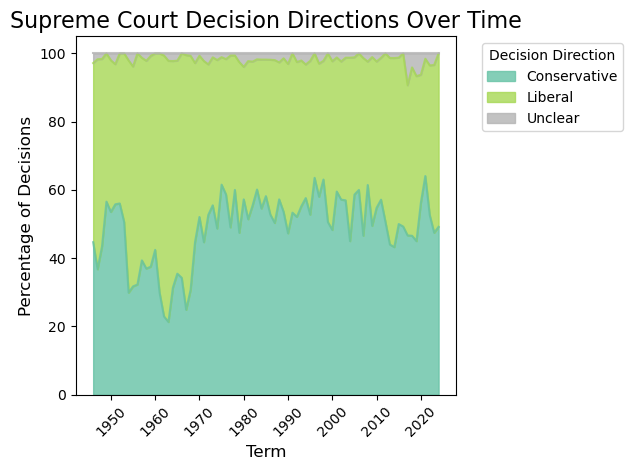

In [7]:
# Convert counts to percentages
direction_by_term_pct = (
    direction_by_term_known
        .div(direction_by_term_known.sum(axis=1), axis=0)
        * 100
)

# Plot stacked area chart
plt.figure(figsize=(14, 7))
direction_by_term_pct.plot(
    kind="area",
    stacked=True,
    colormap="Set2",
    alpha=0.8
)

plt.title("Supreme Court Decision Directions Over Time", fontsize=16)
plt.ylabel("Percentage of Decisions", fontsize=12)
plt.xlabel("Term", fontsize=12)
plt.legend(title="Decision Direction", bbox_to_anchor=(1.05, 1), fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../results/decision_direction_over_time.jpg', format='jpg', dpi=300)
plt.show()

# Observation
# 50s-70s are more conservative
# there is a recent spike in conservative decision since 2020-ish, but still within error or noise range

(266, 3) 

                                                    total_cases  wins  \
petitionerText                                                          
employee, or job applicant, including beneficia...          238   176   
United States                                               875   645   
State                                                       921   639   
governmental official, or an official of an age...          261   173   
union, labor organization, or official of                   187   115   
person accused, indicted, or suspected of crime             654   399   
alien, person subject to a denaturalization pro...          132    76   
governmental employee or job applicant                      132    75   
person convicted of crime                                   514   287   
employer. If employer's relations with employee...          192   101   

                                                    win_rate_pct  
petitionerText                               

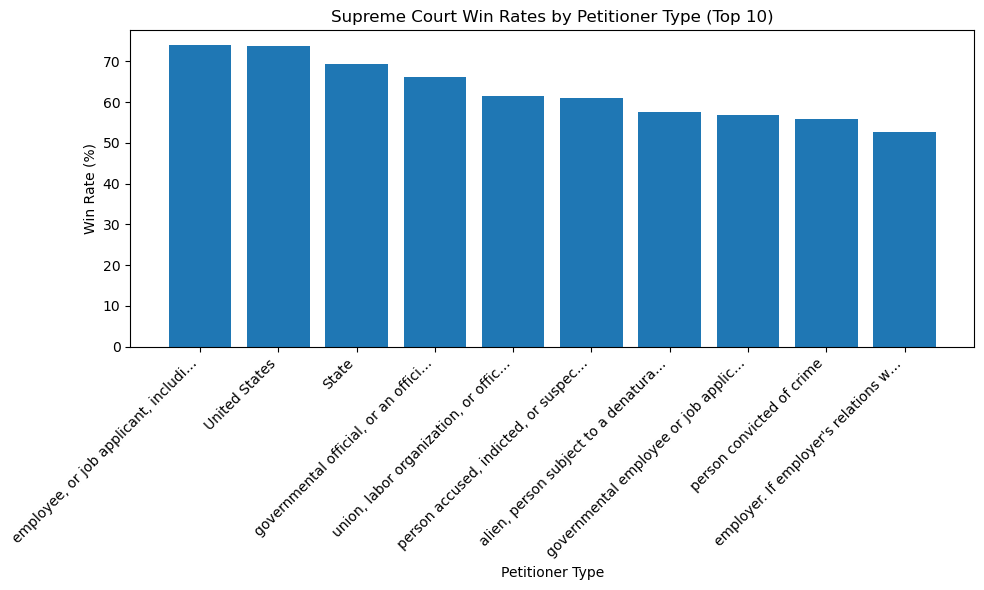

In [19]:
# Win Rates by Petitioner Type
# Which types of parties (e.g., the United States, a state government, a private person, or a corporation) 
# are most successful in getting the Court to rule in their favor?
# petitioner_win = 1 generally means:
# The Supreme Court ruled in favor of the petitioner, which usually means the lower court was not affirmed.

# Define petitioner win
# partyWinning:
# 1 = petitioner won
# 2 = respondent won
# others = unclear / dismissed

# creates a new boolean column that tells whether the petitioner won the case
c_citations["petitioner_win"] = c_citations["partyWinning"] == 1


# Map petitioner codes to English

c_citations["petitionerText"] = (
    c_citations["petitioner"]
    .map(PETITIONER_MAP)
    .fillna("Other / Unknown")
)



# Compute win rates
# .agg() means aggregate, reduce each group down to summary statistics.
# Inside .agg(), new output columns are defined
# name a column total_cased
# Counts how many caseId values are in each petitioner group, which equals to total number of cases in that group
# name another column wins
# Sums the 1s and 0s in petitionar_win column within each group, which equals to the number of wins for that petitioner
# The result is the number of wins for that petitioner

win_rates = (
    c_citations
    .groupby("petitionerText")
    .agg(
        total_cases=("caseId", "count"),
        wins=("petitioner_win", "sum")
    )
)


win_rates["win_rate_pct"] = (
    win_rates["wins"] / win_rates["total_cases"] * 100
)

# check the size of the new table
# should have ten rows for each petitioner type
# should have three columns total_cases, wins, and win_rates
print(win_rates.shape, '\n')

# Sort and get the top 10 (too many petitioner types, can't print or plot all of them)
# win_rates = win_rates.sort_values("win_rate_pct", ascending=False)
# print(win_rates, '\n')

# Filter out petitioner types with very few cases
# For example, ignore any type with fewer than 10 cases
min_cases = 10
win_rates_filtered = win_rates[win_rates["total_cases"] >= min_cases]

# Take the top 10 most common petitioner types by total_cases
top10_common = win_rates_filtered.sort_values("total_cases", ascending=False).head(10)

# Sort these 10 most common petitioner types by win rate (descending)
top10_by_win_rate = top10_common.sort_values("win_rate_pct", ascending=False)

print(top10_by_win_rate, '\n')


# plot

# Truncate labels to first 20 characters (some petitioner type label is too long)
labels = [label[:35] + "…" if len(label) > 35 else label for label in top10_by_win_rate.index]

plt.figure(figsize=(10, 6))

plt.bar(
    labels,
    top10_by_win_rate["win_rate_pct"]
)

plt.title("Supreme Court Win Rates by Petitioner Type (Top 10)")
plt.ylabel("Win Rate (%)")
plt.xlabel("Petitioner Type")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig('../results/win_rate_by_petitioner.jpg', format='jpg', dpi=300)
plt.show()

In [9]:
# Unanimity vs. Division
# What percentage of cases are decided unanimously (9-0) versus closely (5-4 or 6-3)?
# Does this vary by legal area?

# creates a new boolean column that tells whether a Supreme Court decision was unanimous
c_citations["unanimity"] = c_citations["majVotes"] == 9
pct_una = c_citations["unanimity"].sum() / len(c_citations)*100
print(f"The percentage of cases with unanimous vote: {pct_una:.2f}%")
    
# creates a new boolean column that tells whether a Supreme Court decision was very close with 5 vs 4, indicating polar opinions
# do NOT use c_citations["close54"] = c_citations["majVotes"].isin([4, 5]), majVotes can only be 5, if 4, it's not majVotes
c_citations["close5"] = c_citations["majVotes"] == 5
pct_close5 = c_citations["close5"].sum() / len(c_citations)*100
print(f"The percentage of cases with 5 vs 4 vote: {pct_close5:.2f}%")

# creates a new boolean column that tells whether a Supreme Court decision has some consensus with 6/3 or 7/2 votes
c_citations["consen"] = c_citations["majVotes"].isin([6, 7])
pct_consen = c_citations["consen"].sum() / len(c_citations)*100
print(f"The percentage of cases with 6 vs 3 or 7 vs 2 vote: {pct_consen:.2f}%")

# Don't use this, write a more general function instead
# # Get Unanimty rate
# una_rates = (
#     c_citations
#     .groupby("issueAreaText")
#     .agg(
#         total_cases=("caseId", "count"),
#         unas=("unanimity", "sum")
#     )
# )


# una_rates["una_rate_pct"] = (
#     una_rates["unas"] / una_rates["total_cases"] * 100
# )

# print(una_rates, '\n')


The percentage of cases with unanimous vote: 29.14%
The percentage of cases with 5 vs 4 vote: 19.31%
The percentage of cases with 6 vs 3 or 7 vs 2 vote: 33.34%


In [10]:
# calculate unanimous, 5 vs 4 and 7 vs 2 or 6 vs 3 vote probability by issue area

def compute_vote_rate(
    df,                # DataFrame
    group_col,         # column to group by, e.g., "issueAreaText"
    indicator_col,     # boolean column to sum, e.g., "Unanimity" or "close5" or "consen"
    rate_name=None     # optional name for the output percentage column
):
    if rate_name is None:
        rate_name = f"{indicator_col}_rate_pct"
    
    rates = (
        df.groupby(group_col)
          .agg(
              total_cases=("caseId", "count"),
              count_indicator=(indicator_col, "sum")
          )
    )
    
    rates[rate_name] = rates["count_indicator"] / rates["total_cases"] * 100
    
    return rates
    
unan_rates = compute_vote_rate(c_citations, "issueAreaText", "unanimity")
print(unan_rates, '\n')

close5_rates = compute_vote_rate(c_citations, "issueAreaText", "close5")
print(close5_rates, '\n')

consen_rates = compute_vote_rate(c_citations, "issueAreaText", "consen")
print(consen_rates, '\n')

# observation
# Interstate Relations, Judicial Power, Private Law get realtively high rate of unanimous vote 40-50%
# First Amendment is more likely to get polar 5 vs 4 vote 29%
# Miscellaneous often get 6 vs 3 or 7 vs 2 vote 50%

                      total_cases  count_indicator  unanimity_rate_pct
issueAreaText                                                         
Attorneys                     104               34           32.692308
Civil Rights                 1516              433           28.562005
Criminal Procedure           2103              502           23.870661
Due Process                   362               97           26.795580
Economic Activity            1836              560           30.501089
Federal Taxation              320               89           27.812500
Federalism                    417              138           33.093525
First Amendment               707              135           19.094767
Interstate Relations          105               56           53.333333
Judicial Power               1274              521           40.894819
Miscellaneous                  30                5           16.666667
Privacy                       122               36           29.508197
Privat

In [11]:
# Decision Type (such as if ppl agree on the outcome, did they also agree on the reasoning)

c_citations["decisionTypeText"] = (
    c_citations["decisionType"].map(DECISION_TYPE_MAP).fillna("Unknown"))

# print(c_citations["decisionType"].head())

count_decision_type = (
    c_citations
    .groupby('decisionTypeText')
    .size()
    .reset_index(name='count')
)

# Rename columns
count_decision_type.columns = ["decision type", "count"]

count_decision_type_sorted = count_decision_type.sort_values(by='count', ascending=False)
print("\n", print(count_decision_type_sorted.to_string(index=False)))

# Export without index
dfi.export(
    count_decision_type_sorted.style.hide(axis='index'), 
    '../results/tbl_count_decision_type.jpg', 
    table_conversion='matplotlib'
)

                        decision type  count
 Opinion of the court (orally argued)   7323
        Per curiam (no oral argument)   1001
           Per curiam (orally argued)    579
Judgment of the Court (orally argued)    255
                 Equally divided vote    117
                              Decrees     66

 None


In [12]:
# does decision type change drastically depending on the issue area

c_citations["issueAreaText"] = c_citations["issueArea"].map(ISSUE_AREA_MAP).fillna("Unknown")

decision_type_by_area = (
    c_citations
    .pivot_table(
        index="issueAreaText",
        columns="decisionTypeText",
        aggfunc="size",
        fill_value=0
    )
    .sort_index()
)

print(decision_type_by_area.head())

decisionTypeText    Decrees  Equally divided vote  \
issueAreaText                                       
Attorneys                 0                     1   
Civil Rights              1                    13   
Criminal Procedure        0                    12   
Due Process               0                     1   
Economic Activity         0                    19   

decisionTypeText    Judgment of the Court (orally argued)  \
issueAreaText                                               
Attorneys                                               4   
Civil Rights                                           47   
Criminal Procedure                                     84   
Due Process                                            13   
Economic Activity                                      22   

decisionTypeText    Opinion of the court (orally argued)  \
issueAreaText                                              
Attorneys                                             85   
Civil Rights        

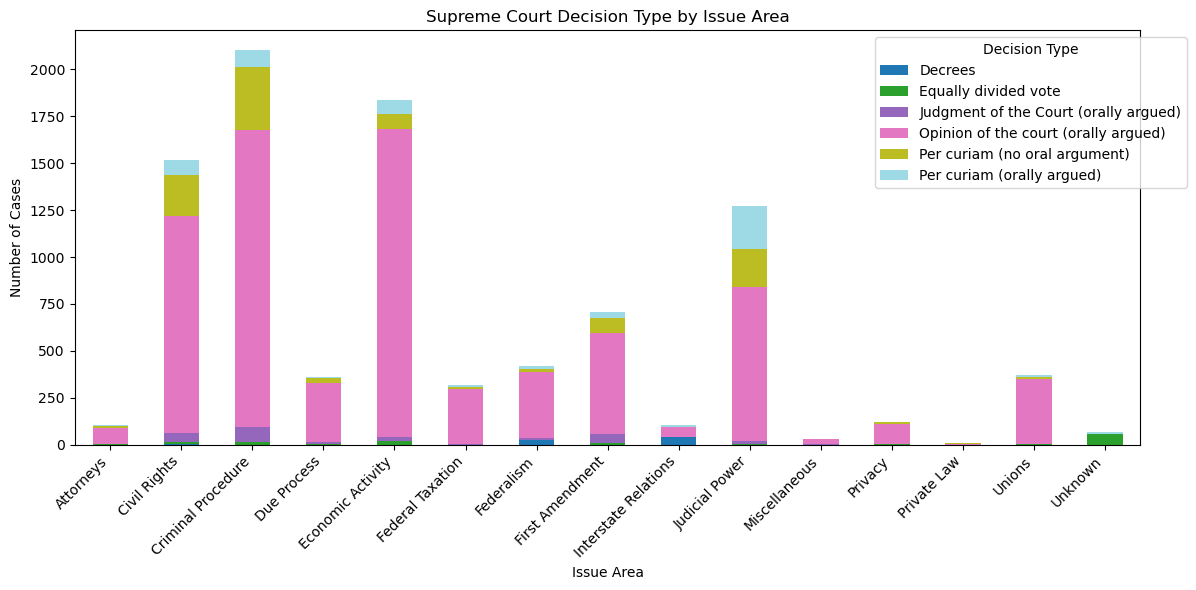

In [13]:
# plot the above

decision_type_by_area.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6),
    colormap='tab20'  # nice colors
)

plt.title("Supreme Court Decision Type by Issue Area")
plt.ylabel("Number of Cases")
plt.xlabel("Issue Area")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Decision Type", bbox_to_anchor=(1.05, 1))
plt.tight_layout()

plt.savefig('../results/decision_type_by_area.jpg', format='jpg', dpi=300)
plt.show()